## Technical assignment week 3

Technical Assignment: Sentiment Analysis System with
Custom Fine-Tuned Model and Llama 3 Models

### Part 1: Dataset Preparation and Fine-Tuning (7 points)
#### Step 1: Download the IMDB Dataset (1 point)
1. Use the IMDB dataset from Kaggle: /kaggle/input/imdb-dataset/IMDB
Dataset.csv.
2. Load the dataset using Pandas and verify it in your notebook.

Load IMDB dataset from kaggle.

In [3]:
#!kaggle datasets list -s IMDB
#!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
#!unzip imdb-dataset-of-50k-movie-reviews.zip

Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


Load using Pandas

In [9]:
import pandas as pd

# load the dataset
imdb_dataset = pd.read_csv("IMDB Dataset.csv")

print(imdb_dataset.head())
imdb_dataset.describe()

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


#### Step 2: Data Preprocessing (1 point)
1. Clean and preprocess the dataset:
- Encode the sentiment column (positive -> 1, negative -> 0).
- Retain only the review and label columns.
2. Split the data into training and validation, testing

In [10]:
# clean the text data
import re

def clean_text(text):
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    return text

imdb_dataset["review"] = imdb_dataset["review"].apply(clean_text)

# remove long sentences (more than 400 words)
#max_length = 400
#imdb_dataset["review_length"] = imdb_dataset["review"].apply(lambda x: len(x.split()))
#imdb_dataset = imdb_dataset[imdb_dataset["review_length"] <= max_length]

imdb_dataset["sentiment"] = imdb_dataset["sentiment"].apply(lambda x: 1 if x == "positive" else 0)

# Display the cleaned dataset
print(imdb_dataset.head())

                                              review  sentiment
0  One of the other reviewers has mentioned that ...          1
1  A wonderful little production  The filming tec...          1
2  I thought this was a wonderful way to spend ti...          1
3  Basically there s a family where a little boy ...          0
4  Petter Mattei s  Love in the Time of Money  is...          1


In [12]:
# split the dataset into training, validation and testing
from sklearn.model_selection import train_test_split

X = imdb_dataset["review"]
y = imdb_dataset["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#### Step 3: Model Selection and Tokenization (1 point)
1. Select a pre-trained Hugging Face transformer model for fine-tuning (e.g.,
distilbert-base-uncased).
2. Tokenize the dataset with (see if required )
- Truncation.
- Padding.
- Maximum sequence length of 256.


Load DistilBERT model

In [13]:
from transformers import DistilBertTokenizer, DistilBertModel

# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

Test tokenizer

In [14]:
# Tokenize imdb dataset
print("Original Sentence: ", imdb_dataset["review"][0])
print("Tokenized Sentence: ", tokenizer(imdb_dataset["review"][0]))

Original Sentence:  One of the other reviewers has mentioned that after watching just 1 Oz episode you ll be hooked  They are right  as this is exactly what happened with me The first thing that struck me about Oz was its brutality and unflinching scenes of violence  which set in right from the word GO  Trust me  this is not a show for the faint hearted or timid  This show pulls no punches with regards to drugs  sex or violence  Its is hardcore  in the classic use of the word It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary  It focuses mainly on Emerald City  an experimental section of the prison where all the cells have glass fronts and face inwards  so privacy is not high on the agenda  Em City is home to many  Aryans  Muslims  gangstas  Latinos  Christians  Italians  Irish and more    so scuffles  death stares  dodgy dealings and shady agreements are never far away I would say the main appeal of the show is due to the fact that it goes w

Tokenize dataset

In [17]:
from datasets import Dataset

# Tokenize the training, validation and testing dataset
train_data = Dataset.from_dict({"text": X_train, "label": y_train})
test_data = Dataset.from_dict({"text": X_test, "label": y_test})
val_data = Dataset.from_dict({"text": X_val, "label": y_val})

def tokenize_function(examples):
    return tokenizer(examples["review"], padding="max_length", truncation=True, max_length=256)

train_data = train_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)
val_data = val_data.map(tokenize_function, batched=True)

Map:   0%|          | 0/32000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Verify datasets

In [18]:
# Display the tokenized dataset
print(train_data)
print(train_data[0])

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 32000
})
{'text': 'With no fault to the actors  they all put on great performances   the overall story was not very well executed  The movie opens with a great zinger  a crazy old guy forces a young Aborigine girl s car off the road  But then  we re forced to endure 40 minutes of character development with an entirely new group of characters     and we don t know why until the 40 minutes are up  It turns out that they are the ones who eventually discover the girl s body     and the story progresses from there While the story does pick up at that point  it really goes nowhere  After 2 hours  I asked myself  was there a point to this  or was it just to see the characters struggle with accusations of racism and stupidity of how they handled the discovery  The story was ultimately unsatisfying and felt unfinished  While it is well acted  there s not a strong enough backbone in the film to warrant recomm

#### Step 4: Fine-Tune the Model (2 points)
1. Fine-tune the model on the IMDB dataset for 2 epochs using the Hugging Face
Trainer.
2. Set training parameters:
- Learning rate: 5e-5 or your own
- Batch size: 16 or 32
- Evaluation at the end of each epoch.
3. Ensure that metrics like accuracy, precision, recall, and F1-score are logged
during training.


Load model and set training arguments.

In [30]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load the distilBERT model
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Define the training arguments
training_args = TrainingArguments(
    './results',
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs = 2,
    logging_steps = 200,
    learning_rate = 5e-5,
    per_device_train_batch_size = 32,
    per_device_eval_batch_size = 32,
    weight_decay=0.01,
    report_to="none",
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Measure metrics, accuracy, precision, recall and F1-score

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

def custom_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1) 
    
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    accuracy = accuracy_score(labels, preds)
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

Define Trainer and train model

In [32]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    compute_metrics=custom_metrics
)

trainer.train()

/home/raati/anaconda3/envs/gptenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.249800,0.226436,0.910125,0.882191,0.948775,0.914272
2,0.132500,0.221339,0.918750,0.920198,0.918832,0.919515


/home/raati/anaconda3/envs/gptenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/raati/anaconda3/envs/gptenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=1000, training_loss=0.2092179012298584, metrics={'train_runtime': 507.8392, 'train_samples_per_second': 126.024, 'train_steps_per_second': 1.969, 'total_flos': 4238956756992000.0, 'train_loss': 0.2092179012298584, 'epoch': 2.0})

Evaluate model

In [29]:
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

/home/raati/anaconda3/envs/gptenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluation Results: {'eval_loss': 0.23785458505153656, 'eval_accuracy': 0.916375, 'eval_precision': 0.91162109375, 'eval_recall': 0.9240287057658996, 'eval_f1': 0.9177829666953423, 'eval_runtime': 22.5144, 'eval_samples_per_second': 355.328, 'eval_steps_per_second': 5.552, 'epoch': 3.0}


#### Step 5: Save and Upload the Model to Hugging Face (2 points)
1. Save the fine-tuned model and tokenizer locally using save_pretrained().
2. Log in to Hugging Face using notebook_login.
3. Upload the model to Hugging Face using push_to_hub.
4. Verify the model on Hugging Face Hub and include the link in your notebook.

In [33]:
# save the model using save_pretrained
model_path = "./distilbert_imdb_sentiment_analysis"
tokenizer_path = "./distilbert_imdb_sentiment_analysis_tokenizer"
model.save_pretrained(model_path)
tokenizer.save_pretrained(tokenizer_path)

('./distilbert_imdb_sentiment_analysis_tokenizer/tokenizer_config.json',
 './distilbert_imdb_sentiment_analysis_tokenizer/special_tokens_map.json',
 './distilbert_imdb_sentiment_analysis_tokenizer/vocab.txt',
 './distilbert_imdb_sentiment_analysis_tokenizer/added_tokens.json')

In [34]:
!pip install --upgrade huggingface_hub

  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.26.2
    Uninstalling huggingface-hub-0.26.2:
      Successfully uninstalled huggingface-hub-0.26.2

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [35]:
from huggingface_hub import notebook_login
notebook_login()

In [36]:
# Reload the model and tokenizer
model.push_to_hub("raati/distilbert_imdb_sentiment_analysis")
tokenizer.push_to_hub("raati/distilbert_imdb_sentiment_analysis_tokenizer")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/raati/distilbert_imdb_sentiment_analysis_tokenizer/commit/754b8a5f3ad48ce47a7bb312dcdf53ec358ee848', commit_message='Upload tokenizer', commit_description='', oid='754b8a5f3ad48ce47a7bb312dcdf53ec358ee848', pr_url=None, repo_url=RepoUrl('https://huggingface.co/raati/distilbert_imdb_sentiment_analysis_tokenizer', endpoint='https://huggingface.co', repo_type='model', repo_id='raati/distilbert_imdb_sentiment_analysis_tokenizer'), pr_revision=None, pr_num=None)

Model and tokenizer has been successfully uploaded to Hugging Face. They can be found from

model: https://huggingface.co/raati/distilbert_imdb_sentiment_analysis

tokenizer: https://huggingface.co/raati/distilbert_imdb_sentiment_analysis_tokenizer

Test loading hugging face model and tokenizer

In [2]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="raati/distilbert_imdb_sentiment_analysis", tokenizer="raati/distilbert_imdb_sentiment_analysis_tokenizer")
print(classifier("This movie was fantastic!"))

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


[{'label': 'LABEL_1', 'score': 0.9886391162872314}]


Model seems to classify sentence correctly as positive (label 1 = positive)

### Part 2: API Development and Testing (5 points)
#### Step 6: Set Up the Backend API (1 point)
1. Use FastAPI or Flask, Express, Nest Nodejs to create an API.
2. Define a POST endpoint (/analyze/) that:
- Accepts:
    - text: The input text for sentiment analysis.
    - model: A parameter specifying the model to use (custom or llama).
- Returns:
    - Sentiment (positive or negative).
    - Confidence score.


POST endpoint can be found from backend/api/routes.py. The input is validated using Pydantic and handles input forwarding to correct model.

Endpoint:
```python
@router.post("/analyze")
def analyze_sentiment(request: AnalystRequest):
    """Endpoint to analyze text"""
    try:

        if request.model == "custom":
            result = analyze_transformer(request.text)

        elif request.model == "llama":
            result = analyze_llama(request.text)
        else:
            raise HTTPException(status_code=400, detail="Invalid model, provide 'custom' or 'llama'")
        return AnalystResponse(sentiment=result.sentiment, score=result.score)
    
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))
```

#### Step 7: Load Models (1 point)
1. Load the fine-tuned model from Hugging Face.
2. Access the Llama 3 model using the Groq Cloud API.

This step implementations can be found from backend/services/ in groq.py and transformers.py.

#### Step 8: Test the API Locally (1 point)
1. Test the /analyze/ endpoint with both models (custom and llama) using:
- Postman.
- curl.
- Python requests.

I used Bruno (similar to Postman), Succesfully connected to /analyze endpoint with expected output.

Screenshot of Bruno:

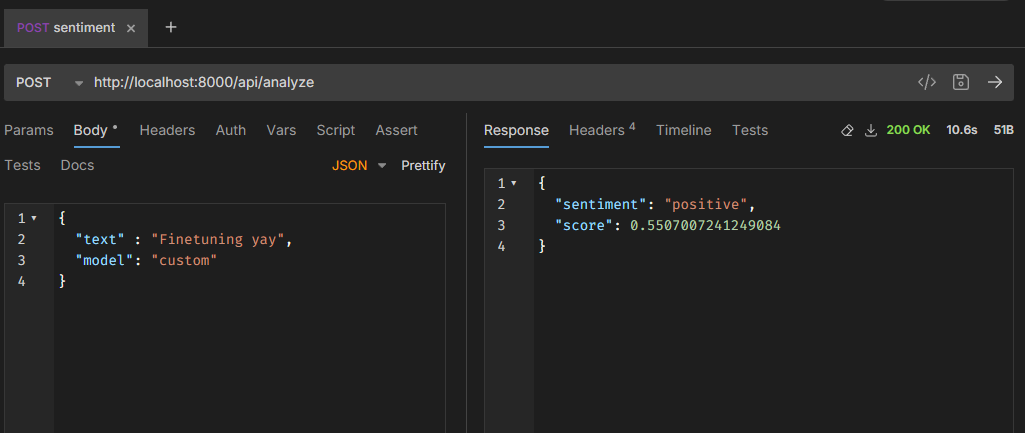

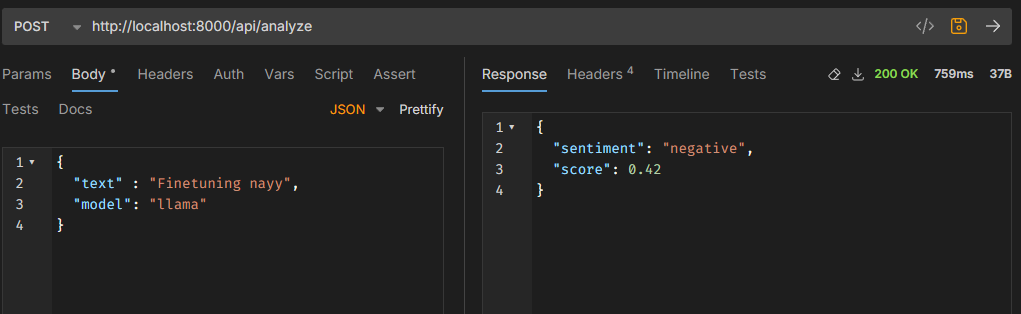


Python requests are tested using the frontend UI.


Curl:

```bash
(gptenv) (base) raati@rati:~/fine-tuning$ curl -X POST http://localhost:8000/api/analyze \
  -H "Content-Type: application/json" \
  -d '{"text": "Finetuning nayy", "model": "llama"}'
{"sentiment":"negative","score":0.52
```

#### Step 9: Define the Llama 3 Prompt (1 point)
1. Write a clear and reusable prompt for the Llama 3 model in Groq Cloud.
Example: can be improved more

Llama prompt was enhanced from the template to:

```md
You are a sentiment analysis assistant. Analyze the given text and return a JSON object with two fields:
        - "sentiment": Either "positive" or "negative".
        - "score": A float between 0 and 1 representing confidence in classification.
        
        Example output:
        {"sentiment": "positive", "score": 0.87} 
```

This prompt succesfully includes the example output in output. However, for difficult sentiments (including both positive and negative sentiments) output often includes plenty of jargon. Thus, output is validated into JSON format properly by finding the JSON formatted structure from the message. This method removed the issue from most cases.

#### Step 10: Test with Both Models (1 point)
1. Verify that the API works for both the fine-tuned model and the Llama 3 model.
2. Ensure the results return the sentiment score too.
3. For Groq you can add into prompt,


Both models work as they should.

### Part 3: UI Design and Explanation (3 points)
#### Step 11: React UI Design (1 point)
- A text input field for user input.
- A dropdown menu for model selection:
    - Custom Model.
    - Llama 3.
- A button labeled "Analyze Sentiment" to send input and selected model to the
backend API.
- A result display section showing:
    - Sentiment (positive or negative).
    - Confidence score(optional)


#### Step 12: Submit GitHub Repository (1 point)

.

#### Step 13: Record a YouTube Demo Video (1 point)
1. Record a demo video (2-3 minutes) showing:
- Testing the system with both models (custom and llama).
- One question with custom fine and one with llam3 any llama 3 will be fine.
2. Upload the video to YouTube and include the link in your notebook.

--